# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

В рамках проекта требуется простроить модель, которая по фотографии определит приблизительный возраст человека. Для работы над проектом предоставлен набор фотографий людей с указанием возраста.

Для решения поставленной задачи будут выполнены следующие этапы:
* исследовательский анализ данных;
* обучение модели;
* анализ обученной модели. 

Для проекта потребуется построить свёрточную нейронную сеть на датасете с фотографиями людей. В результате значение метрики MAE (средняя абсолютная ошибка) на тестовой выборке должно быть не больше 8.

В проект будут реализованы следующие функции:

* load_train(path) - загрузка обучающих данных,
* load_test(path) - загрузка тестовых данных,
* create_model(input_shape) - построение модели,
* train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps) -обучение модели.

В [статье о датасете](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), который будет использован в проекте, значение MAE равно 5.4 — если в результате будет получена MAE меньше 7, это будет отличный результат!

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale = 1./255)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## Исследовательский анализ данных

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


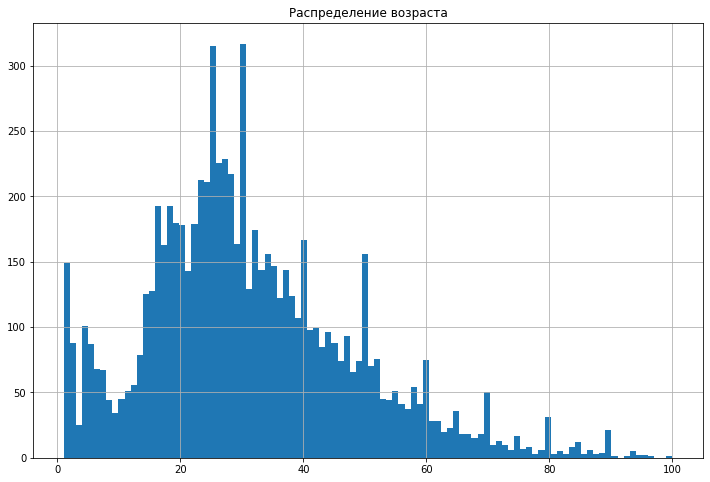

In [6]:
plt.subplots(figsize=(12, 8))
labels['real_age'].hist(bins=100)
plt.title('Распределение возраста');

In [7]:
features, target = next(train_gen_flow)

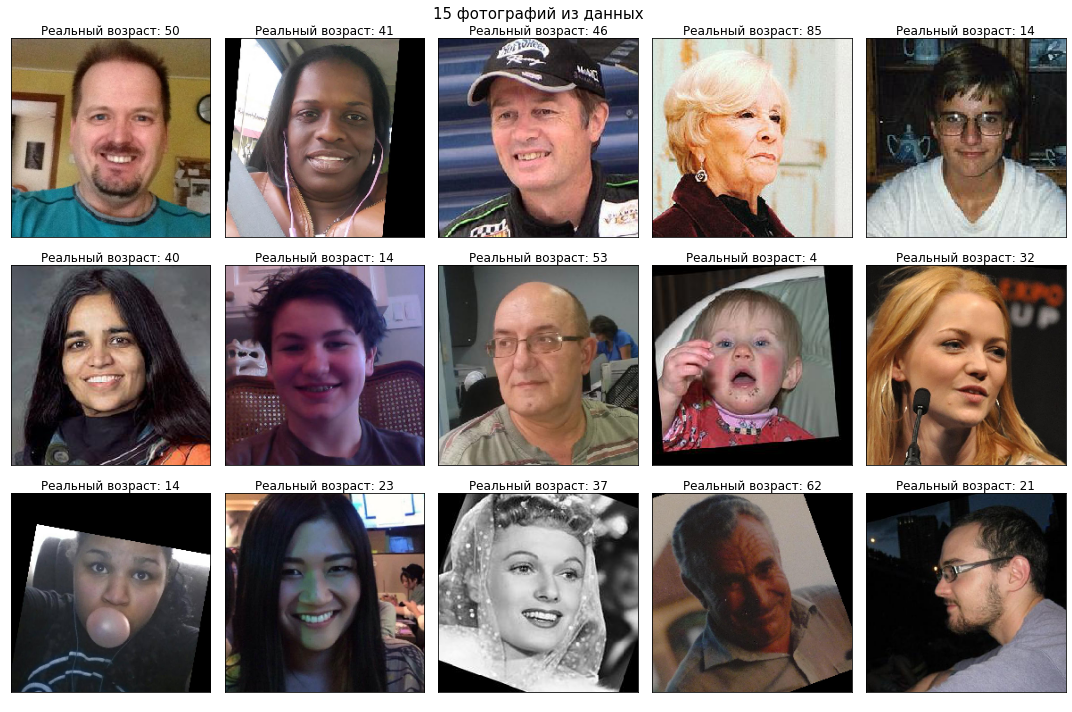

In [8]:
fig = plt.figure(figsize=(15,10))
plt.title('15 фотографий из данных',fontsize=15)
plt.axis('off')
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title(f"Реальный возраст: {target[i]}", pad=-10)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**
* В данных представлено более 7,5 тысяч фотографий.
* Каждой фотографии соответствует метка с возрастом человека, изображенного на фото.
* Пропусков в данных не обнаружено.
* На фотографиях лица изорбражены крупным планом, в центре фотографии: в некоторых случаях человек изображен в профиль, иногда в анфас, иногда лицо частично скрыто предметом или границами фото.
* Средний возраст составляет 31 год. Возраст людей, изображенных на фотографиях, варьируется от 1 года до 100 лет.
* Судя по гистограмме распределения возраста, имеются пиковые значения, соответствующие пятилетним периодам (например, 20, 25, 30, 35 лет и т.д.). Возможно это связано с тем, что при разметке данных возраст округляется до ближайшего пятилетия.
* Т.к. представленных данных больше для людей в возрасте от 20 до 40 лет, модель будет лучше обучаться именно на этом возрастном диапазоне и может завышать возраст молодых людей и занижать возраст пожилых людей.
* Потребуется использование метода аугментации для дополнения обучающего набора с целью повышения качества нейронной сети.

## Обучение модели

Для построения нейронной сети используем архитектуру **ResNet**.   
Для тренировочной и валидационной выборок создаются отдельные генераторы, но указываем для них одинаковый seed.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

labels = pd.read_csv('/datasets/faces/labels.csv')
path = '/datasets/faces/final_files/'

def load_train(path):
    
    train_datagen = ImageDataGenerator(validation_split = 0.25, 
                                       rescale = 1./255, 
                                       horizontal_flip = True, 
                                       height_shift_range=0.2,
                                       width_shift_range=0.2)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=12345)
    
    return train_gen_flow

def load_test(path):
   
    test_datagen = ImageDataGenerator(validation_split = 0.25, 
                                      rescale = 1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed=12345)
        
    return test_gen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape = input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
        
    model = Sequential()

    optimizer = Adam(lr = 0.0001)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=14,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, verbose = 2)
    
    return model

```

**Результат выполнения кода**

```

Train for 178 steps, validate for 60 steps
Epoch 1/14
2023-07-07 13:04:45.713972: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-07 13:04:46.200864: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 100s - loss: 239.5333 - mae: 11.0702 - val_loss: 905.3370 - val_mae: 25.2521
Epoch 2/14
178/178 - 92s - loss: 92.8984 - mae: 7.2547 - val_loss: 538.9200 - val_mae: 18.0020
Epoch 3/14
178/178 - 96s - loss: 71.0455 - mae: 6.3750 - val_loss: 218.2577 - val_mae: 10.9727
Epoch 4/14
178/178 - 101s - loss: 55.7953 - mae: 5.7315 - val_loss: 140.5982 - val_mae: 8.9524
Epoch 5/14
178/178 - 99s - loss: 48.7928 - mae: 5.3516 - val_loss: 110.4914 - val_mae: 7.8576
Epoch 6/14
178/178 - 93s - loss: 40.6460 - mae: 4.8743 - val_loss: 77.9417 - val_mae: 6.5991
Epoch 7/14
178/178 - 95s - loss: 36.1063 - mae: 4.6350 - val_loss: 79.2752 - val_mae: 6.6288
Epoch 8/14
178/178 - 95s - loss: 30.6859 - mae: 4.2897 - val_loss: 66.0233 - val_mae: 6.1367
Epoch 9/14
178/178 - 95s - loss: 27.9822 - mae: 4.0916 - val_loss: 88.2911 - val_mae: 7.2332
Epoch 10/14
178/178 - 96s - loss: 24.9399 - mae: 3.8841 - val_loss: 70.3401 - val_mae: 6.3411
Epoch 11/14
178/178 - 94s - loss: 22.5094 - mae: 3.6814 - val_loss: 102.8809 - val_mae: 7.5209
Epoch 12/14
178/178 - 94s - loss: 22.3493 - mae: 3.6036 - val_loss: 90.5139 - val_mae: 6.7712
Epoch 13/14
178/178 - 92s - loss: 20.1792 - mae: 3.4484 - val_loss: 64.8533 - val_mae: 6.0180
Epoch 14/14
178/178 - 94s - loss: 17.7059 - mae: 3.2364 - val_loss: 63.1068 - val_mae: 5.9249
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 63.1068 - mae: 5.9249
Test MAE: 5.9249

```

В результате имеем достаточно хорошее значение **MAE**, равную **5.9249**.

## Анализ обученной модели

Целью проекта была разработка модели, предсказывающей возраст человека по фотографии. Метрика MAE по условиям задачи не должна быть больше 8.

Перед построением модели был выполнен **исследовательский анализ данных**, результаты которого следующие:

* В данных представлено более 7,5 тысяч фотографий.
* Каждой фотографии соответствует метка с возрастом человека, изображенного на фото.
* Пропусков в данных не обнаружено.
* На фотографиях лица изорбражены крупным планом, в центре фотографии: в некоторых случаях человек изображен в профиль, иногда в анфас, иногда лицо частично скрыто предметом или границами фото.
* Средний возраст составляет 31 год. Возраст людей, изображенных на фотографиях, варьируется от 1 года до 100 лет.
* Судя по гистограмме распределения возраста, имеются пиковые значения, соответствующие пятилетним периодам (например, 20, 25, 30, 35 лет и т.д.). Возможно это связано с тем, что при разметке данных возраст округляется до ближайшего пятилетия.
* Т.к. представленных данных больше для людей в возрасте от 20 до 40 лет, модель будет лучше обучаться именно на этом возрастном диапазоне и может завышать возраст молодых людей и занижать возраст пожилых людей.
* Потребуется использование метода аугментации для дополнения обучающего набора с целью повышения качества нейронной сети.

Перед созданием модели были применены следующие методы **аугментации**:
* горизонтальное отображение;
* сдвиги изображения по вертикали и горизонтали на 20% от исходного размера.

Для выполнения поставленной залачи была создана **сверточная нейронная сеть** на основе архитектуры **ResNet50** (глубина 50 слоев). На тестовой выборке значение метрики **MAE** достигло **5.9249**. Общее **количество эпох** составило **14**.